In [1]:
import numpy as np
import pandas as pd
import os
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn import tree
from sklearn import model_selection
from sklearn import ensemble
import matplotlib.pyplot as plt

# Reading Data

In [2]:
def segmentWords(s): 
    return s.split()

def readFile(fileName):
    # Function for reading file
    # input: filename as string
    # output: contents of file as list containing single words
    contents = []
    f = open(fileName)
    for line in f:
        contents.append(line)
    f.close()
    result = segmentWords('\n'.join(contents))
    return result

#### Create a Dataframe containing the counts of each word in a file

In [3]:
d = []

for c in os.listdir("data_training"):
    directory = "data_training/" + c
    for file in os.listdir(directory):
        words = readFile(directory + "/" + file)
        e = {x:words.count(x) for x in words}
        e['__FileID__'] = file
        e['__CLASS__'] = 'positive' if c=='pos' else 'negative'
        d.append(e)

Create a dataframe from d - make sure to fill all the nan values with zeros.

References:

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html


In [4]:
df = pd.DataFrame(d)
df.fillna(0, inplace=True)

#### Split data into training and validation set 

* Sample 80% of your dataframe to be the training data

* Let the remaining 20% be the validation data (you can filter out the indicies of the original dataframe that weren't selected for the training data)

References:

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html

In [5]:
train = df.sample(frac=0.8, random_state=42)
test = df.drop(list(train.index))

* Split the dataframe for both training and validation data into x and y dataframes - where y contains the labels and x contains the words

References:

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html

In [6]:
y_train = train[['__CLASS__']]
y_test = test[['__CLASS__']]
X_train = train.drop(['__CLASS__', '__FileID__'], axis=1)
X_test = test.drop(['__CLASS__', '__FileID__'], axis=1)

# Logistic Regression

#### Basic Logistic Regression
* Use sklearn's linear_model.LogisticRegression() to create your model.
* Fit the data and labels with your model.
* Score your model with the same data and labels.

References:

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [7]:
model = LogisticRegression()
model.fit(X_train, y_train)
print("Train score: " + str(model.score(X_train, y_train)))
print("Test score: " + str(model.score(X_test, y_test)))

C:\Users\Jun Seo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train score: 1.0
Test score: 0.796875


#### Changing Parameters

In [8]:
for p in ['l1', 'l2']:
    for c in [0.001, 0.005, 0.01, 0.05, 1]:
        model2 = LogisticRegression(C=c, penalty=p)
        model2.fit(X_train, y_train)
        print("C=" + str(format(c, '.3f')) + ", penalty=" + str(p) + ":     Train score = " + 
              str(format(model2.score(X_train, y_train), '.6f'))
             + ",  Test score = " + str(format(model2.score(X_test, y_test), '.6f')))

C:\Users\Jun Seo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


C=0.001, penalty=l1:     Train score = 0.490625,  Test score = 0.540625
C=0.005, penalty=l1:     Train score = 0.639844,  Test score = 0.640625
C=0.010, penalty=l1:     Train score = 0.692969,  Test score = 0.671875
C=0.050, penalty=l1:     Train score = 0.844531,  Test score = 0.765625
C=1.000, penalty=l1:     Train score = 1.000000,  Test score = 0.796875
C=0.001, penalty=l2:     Train score = 0.878125,  Test score = 0.762500
C=0.005, penalty=l2:     Train score = 0.977344,  Test score = 0.809375
C=0.010, penalty=l2:     Train score = 0.989844,  Test score = 0.806250
C=0.050, penalty=l2:     Train score = 1.000000,  Test score = 0.812500
C=1.000, penalty=l2:     Train score = 1.000000,  Test score = 0.796875


#### Feature Selection
* In the backward stepsize selection method, you can remove coefficients and the corresponding x columns, where the coefficient is more than a particular amount away from the mean - you can choose how far from the mean is reasonable.

References:

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html#
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.where.html
https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.std.html
https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.mean.html

In [9]:
weights = (np.array(model.coef_[0])-np.mean(model.coef_[0]))/np.std(model.coef_[0])
X_train_bss = X_train.iloc[:, np.where(np.abs(weights)>3)[0].tolist()]
X_test_bss = X_test.iloc[:, np.where(np.abs(weights)>3)[0].tolist()]

for p in ['l1', 'l2']:
    for c in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]:
        model3 = LogisticRegression(C=c, penalty=p)
        model3.fit(X_train_bss, y_train)
        #print("C= " + str(c) + ": Train score = " + str(model3.score(X_train_bss, y_train))
        #     + ", Test score = " + str(model3.score(X_test_bss, y_test)))
        print("C=" + str(format(c, '.4f')) + ", penalty=" + str(p) + ":     Train score = " + 
                  str(format(model3.score(X_train_bss, y_train), '.6f'))
                 + ",  Test score = " + str(format(model3.score(X_test_bss, y_test), '.6f')))

C=0.0010, penalty=l1:     Train score = 0.490625,  Test score = 0.540625
C=0.0050, penalty=l1:     Train score = 0.631250,  Test score = 0.600000
C=0.0100, penalty=l1:     Train score = 0.683594,  Test score = 0.671875


C:\Users\Jun Seo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


C=0.0500, penalty=l1:     Train score = 0.825781,  Test score = 0.787500
C=0.1000, penalty=l1:     Train score = 0.894531,  Test score = 0.778125
C=0.5000, penalty=l1:     Train score = 0.998437,  Test score = 0.768750
C=1.0000, penalty=l1:     Train score = 1.000000,  Test score = 0.775000
C=0.0010, penalty=l2:     Train score = 0.860938,  Test score = 0.768750
C=0.0050, penalty=l2:     Train score = 0.950000,  Test score = 0.793750
C=0.0100, penalty=l2:     Train score = 0.973437,  Test score = 0.796875
C=0.0500, penalty=l2:     Train score = 0.999219,  Test score = 0.812500
C=0.1000, penalty=l2:     Train score = 1.000000,  Test score = 0.818750
C=0.5000, penalty=l2:     Train score = 1.000000,  Test score = 0.825000
C=1.0000, penalty=l2:     Train score = 1.000000,  Test score = 0.821875


In [10]:
X_train_bss.shape

(1280, 1011)

How did you select which features to remove? Why did that reduce overfitting?

Removed features based on weight. Based on different C values, c=0.05 and penalty='l1' performed well while decreasing the overfitting on the train set.

# Single Decision Tree

#### Basic Decision Tree

* Initialize your model as a decision tree with sklearn.
* Fit the data and labels to the model.

References:

http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html


In [15]:
dtree = tree.DecisionTreeClassifier(max_depth=40)
dtree = dtree.fit(X_train, y_train)

In [16]:
print(dtree.score(X_train, y_train))
print(dtree.score(X_test, y_test))

1.0
0.63125


#### Changing Parameters
* To test out which value is optimal for a particular parameter, you can either loop through various values or look into sklearn.model_selection.GridSearchCV

References:


http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

How did you choose which parameters to change and what value to give to them? Feel free to show a plot.

In [17]:
c, r = np.shape(y_train)
y_train_reshape = np.reshape(y_train, (c,))

params = {"max_depth": [10,20,30,40,50]}
gscv = model_selection.GridSearchCV(dtree, params)
gscv = gscv.fit(X_train.values, y_train_reshape.values.reshape((c,)))

In [18]:
gscv.cv_results_

{'mean_fit_time': array([ 6.59381159,  7.13364633,  6.38297025,  6.33252009,  7.24861908]),
 'mean_score_time': array([ 0.0862515 ,  0.07942883,  0.07935596,  0.07526914,  0.08846656]),
 'mean_test_score': array([ 0.6234375 ,  0.62578125,  0.6265625 ,  0.628125  ,  0.628125  ]),
 'mean_train_score': array([ 0.94216849,  1.        ,  1.        ,  1.        ,  1.        ]),
 'param_max_depth': masked_array(data = [10 20 30 40 50],
              mask = [False False False False False],
        fill_value = ?),
 'params': [{'max_depth': 10},
  {'max_depth': 20},
  {'max_depth': 30},
  {'max_depth': 40},
  {'max_depth': 50}],
 'rank_test_score': array([5, 4, 3, 1, 1]),
 'split0_test_score': array([ 0.58411215,  0.60747664,  0.5817757 ,  0.59813084,  0.59813084]),
 'split0_train_score': array([ 0.91784038,  1.        ,  1.        ,  1.        ,  1.        ]),
 'split1_test_score': array([ 0.6056338 ,  0.5915493 ,  0.61502347,  0.61971831,  0.60328638]),
 'split1_train_score': array([ 0.966042

Why is a single decision tree so prone to overfitting?

In [19]:
x = [10,20,30,40,50]
y = [tree.DecisionTreeClassifier(max_depth=k).fit(X_train,y_train_reshape).score(X_test,y_test) for k in x]

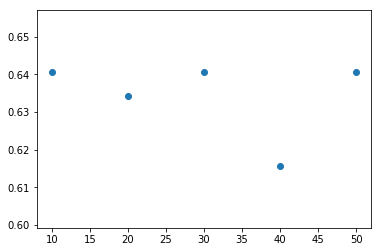

In [20]:
plt.scatter(x,y)
plt.show()

A single decision tree can make a lot of branches, and these branches are often only relevant for certain samples. These branches are basically useless because they're not generalized. Therefore, by decreasing the max depth in our classifier, we prevent the creation of these sample-specific branches and prevent our tree from overfitting.

# Random Forest Classifier

#### Basic Random Forest

* Use sklearn's ensemble.RandomForestClassifier() to create your model.
* Fit the data and labels with your model.
* Score your model with the same data and labels.

References:

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


In [21]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train,y_train.values.ravel())
print("Basic Random Forest Classifier score for training data is " + str(clf.score(X_train, y_train.values.ravel())))
print("Basic Random Forest Classifier score for test data is " + str(clf.score(X_test, y_test.values.ravel())))   

Basic Random Forest Classifier score for training data is 0.9875
Basic Random Forest Classifier score for test data is 0.659375


#### Changing Parameters

In [22]:
clf.set_params(n_estimators = 400, max_features=(int(clf.n_features_ * .25)))
clf.fit(X_train,y_train.values.ravel())
print("New Paramters Random Forest Classifier score for training data is " + str(clf.score(X_train, y_train.values.ravel())))
print("New Parameters Random Forest Classifier score for test data is " + str(clf.score(X_test, y_test.values.ravel())))

New Paramters Random Forest Classifier score for training data is 1.0
New Parameters Random Forest Classifier score for test data is 0.7875


What parameters did you choose to change and why?

In [ ]:
'''We chose to change n_estimators because the more trees in a random forest the more accurate the classifier. 
We also decided to change the max_features parameter to prevent overfitting and bring down the training
time for our random forest'''

How does a random forest classifier prevent overfitting better than a single decision tree?

In [ ]:
'''This happens because overfitting often happens because of high amounts of variance. Random forest classifiers 
inherently have less variance because they average out the variance in single decision trees.
'''